### Visualising the data

#### What files are in the input folder:

In [1]:
# All imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import gc


In [ ]:
import os 
print('No. of files: {}'.format(str(len(os.listdir("./input")))))
print(os.listdir("./input"))

##### Train and Test files

In [ ]:
import pandas as pd

e = pd.read_excel('./input/Data_Dictionary.xlsx', sheetname='train')
e

In [ ]:
#Loading Train and Test Data

df_train = pd.read_csv("./input/train.csv", parse_dates=["first_active_month"])
df_test = pd.read_csv("./input/test.csv", parse_dates=["first_active_month"])
print("{} observations and {} features in train set.".format(df_train.shape[0],df_train.shape[1]))
print("{} observations and {} features in test set.".format(df_test.shape[0],df_test.shape[1]))

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
df_test.head()

Let's now look at the target score 

In [ ]:
df_train.target.describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_train.target.values, bins=500)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

In [ ]:
print('There are {0} samples with target lower than -25.'.format(df_train.loc[df_train.target < -25].shape[0]))

In [ ]:
# sort values
df_train = df_train.sort_values(by=['target'], axis=0)

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(df_train.target.values[:2207], bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

df_train_outliers = pd.Series(df_train.target.values[:2207])
df_train_outliers.describe()

One unique target value for 2207 outliers: -33.21928


Let's now look at the distributions of various "features"

Feature 1

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4));
df_train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='train feature_1');
df_test['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='test feature_1');
plt.suptitle('Histogram feature_1 counts');
plt.show()

Feature 2

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4));
df_train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='train feature_2');
df_test['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='test feature_2');
plt.suptitle('Histogram feature_2 counts');
plt.show()

Feature 3

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4));
df_train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='train feature_3');
df_test['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='test feature_3');
plt.suptitle('Histogram feature_3 counts');
plt.show()

- These two plots show an important idea: while different categories of these features could have various counts, the distribution of target is almost the same. This could mean, that these features aren't really good at predicting target - we'll need other features and feature engineering. Also it is worth noticing that mean target values of each catogory of these features is near zero. This could mean that data was sampled from normal distribution.
    

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

d1 = df_train['first_active_month'].value_counts().sort_index()
d2 = df_test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

Observations:

- Trends of counts for train and test data are similar, and this is great. Why there is such a sharp decline at the end of the period? I think it was on purpose. Or maybe new cards are taken into account only after fulfilling some conditions.


##### Historical Transactions
Up to 3 months' worth of historical transactions for each card_id

In [ ]:
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheetname='history')
e

In [ ]:
#Loading historical transaction Data
import pandas as pd

df_historical_transactions = pd.read_csv('./input/historical_transactions.csv')
print(f'{df_historical_transactions.shape[0]} samples in data')
df_historical_transactions.head(12)


Authorized flag

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4));
df_historical_transactions['authorized_flag'].value_counts().sort_index().plot(kind='bar', ax=ax, color='teal', title='');
plt.suptitle('Authorized flag');
plt.show()

In [ ]:
df_historical_transactions['authorized_flag'].value_counts(normalize=True)

In [ ]:
# let's convert the authorized_flag to a binary value.
df_historical_transactions['authorized_flag'] = df_historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
autorized_card_rate = df_historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head(20)

In [ ]:
print("Cards with low to 50/50 no. of authorized transactions {}".format(len([1 for x in autorized_card_rate if x < 0.50])))

In [ ]:
print("Cards with perfect authorized transactions {}".format(len([1 for x in autorized_card_rate if x > 0.99999])))

Installments

In [ ]:
df_historical_transactions['installments'].value_counts()

Observation:
what are -1 and 999??? Are they filling in for missing values??

In [ ]:
df_historical_transactions.groupby(['installments'])['authorized_flag'].mean()

On the other hand it seems that 999 could mean fraud transactions, considering only 3% of these transactions were approved. One more interesting thing is that the higher the number of installments is, the lower is the approval rate.

Purchase Amount

Purchase_amount is normalized.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df_historical_transactions['purchase_amount'].values, bins=500, range=(-1, 0))
plt.title('Histogram showing Purchase Amounts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
for i in [-1, 0]:
    n = df_historical_transactions.loc[df_historical_transactions['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = df_historical_transactions.loc[df_historical_transactions['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

Observation:
- It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

Categories

In [ ]:
df_historical_transactions['category_1'].value_counts()

In [ ]:
nan_rows = df_historical_transactions[df_historical_transactions['category_1'].isnull()]
print("Number of category_1 rows with null values: {} ".format(len(nan_rows.values)))

In [ ]:
map_dict = {'Y': 0, 'N': 1}
df_historical_transactions['category_1'] = df_historical_transactions['category_1'].apply(lambda x: map_dict[x])
df_historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

In [ ]:
df_historical_transactions['category_2'].value_counts()

In [ ]:
nan_rows = df_historical_transactions[df_historical_transactions['category_2'].isnull()]
print("Number of category_2 rows with null values: {} ".format(len(nan_rows.values)))

In [ ]:
df_historical_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

In [ ]:
df_historical_transactions['category_3'].value_counts()

In [ ]:
nan_rows = df_historical_transactions[df_historical_transactions['category_3'].isnull()]
print("Number of category_3 rows with null values: {} ".format(len(nan_rows.values)))

In [ ]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
df_historical_transactions['category_3'] = df_historical_transactions['category_3'].apply(lambda x: map_dict[str(x)])
df_historical_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

Quick summary of the rest of the properties in historical transactions

In [ ]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {df_historical_transactions[col].nunique()} unique values in {col}.")

##### New Merchant Transactions
Two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [ ]:
df_new_merchant_transactions = pd.read_csv('./input/new_merchant_transactions.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

In [ ]:
print(f'{df_new_merchant_transactions.shape[0]} samples in data')
df_new_merchant_transactions.head()

In [ ]:
# let's convert the authorized_flag to a binary value.
df_new_merchant_transactions['authorized_flag'] = df_new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
print(f"At average {df_new_merchant_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
df_new_merchant_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In contrast with historical data, all transactions here were authorized!
<BR>

Cards with lowest and highest total purchase amount¶

In [ ]:
card_total_purchase = df_new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()
card_total_purchase.head()

In [ ]:
card_total_purchase.tail()

It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

Installments

In [ ]:
df_new_merchant_transactions['installments'].value_counts()

Interesting. Most common number of installments are 0 and 1 which is expected. But -1 and 999 are strange. I think that these values were used to fill in missing values.

In [ ]:
df_new_merchant_transactions.groupby(['installments'])['purchase_amount'].sum()

In [ ]:
df_new_merchant_transactions['installments'] = df_new_merchant_transactions['installments'].astype('category')

purchase_amount<BR>
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

In [ ]:
plt.title('Purchase amount distribution.');
df_new_merchant_transactions['purchase_amount'].plot(kind='hist');
plt.show()

In [ ]:
for i in [-1, 0]:
    n = df_new_merchant_transactions.loc[df_new_merchant_transactions['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = df_new_merchant_transactions.loc[df_new_merchant_transactions['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

In [ ]:
plt.title('Purchase amount distribution for negative values.');
df_new_merchant_transactions.loc[df_new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');
plt.show()

It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.
<BR>
Categories

In [ ]:
map_dict = {'Y': 0, 'N': 1}
df_new_merchant_transactions['category_1'] = df_new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
df_new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

In [ ]:
df_new_merchant_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count']})

In [ ]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
df_new_merchant_transactions['category_3'] = df_new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
df_new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

All categories are quite different

In [ ]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {df_new_merchant_transactions[col].nunique()} unique values in {col}.")

##### Merchants


### Cleaning and fixing data

**Train file**

- There are no null values in the train data!

Change the datatype to categories for the features

In [ ]:
df_train['feature_1'] = df_train['feature_1'].astype('category')
df_train['feature_2'] = df_train['feature_2'].astype('category')
df_train['feature_3'] = df_train['feature_3'].astype('category')

**Test file**

In [ ]:
nan_rows = df_test[df_test['first_active_month'].isnull()]
print(nan_rows)

Fill missing value with the first data instance having the same values of three features.

In [ ]:
df_test.loc[df_test['first_active_month'].isnull(), 'first_active_month'] = df_test.loc[(df_test['feature_1'] == 5) & (df_test['feature_2'] == 2) & (df_test['feature_3'] == 1), 'first_active_month'].min()

In [ ]:
df_test['feature_1'] = df_test['feature_1'].astype('category')
df_test['feature_2'] = df_test['feature_2'].astype('category')
df_test['feature_3'] = df_test['feature_3'].astype('category')

**Historical Transactions**

In [ ]:
df_historical_transactions.info()

In [ ]:
df_historical_transactions['installments'] = df_historical_transactions['installments'].astype('category')
df_historical_transactions['purchase_date'] = pd.to_datetime(df_historical_transactions['purchase_date'])

df_historical_transactions['category_1'] = df_historical_transactions['category_1'].astype('int64')
df_historical_transactions['category_2'] = df_historical_transactions['category_2'].astype('float64')
df_historical_transactions['category_3'] = df_historical_transactions['category_3'].astype('int64')

In [ ]:
df_historical_transactions.info()

**New Merchant Transactions**

In [ ]:
df_new_merchant_transactions.info()

In [ ]:
df_new_merchant_transactions['installments'] = df_new_merchant_transactions['installments'].astype('category')
df_new_merchant_transactions['purchase_date'] = pd.to_datetime(df_new_merchant_transactions['purchase_date'])

### Feature engineering

Train & Test data

In [ ]:
max_date = df_train['first_active_month'].dt.date.max()

def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

df_train = process_main(df_train)
df_test = process_main(df_test)

Historical Transactions

In [ ]:
import numpy as np
import datetime

def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
                                        astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)

    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'month_diff': ['min', 'max', 'mean']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [ ]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(df_historical_transactions) 

In [ ]:
history = aggregate_historical_transactions(df_historical_transactions, prefix='hist_')

In [ ]:
df_train = pd.merge(df_train, history, on='card_id', how='left')
df_test = pd.merge(df_test, history, on='card_id', how='left')
del history

In [ ]:
import gc

del df_historical_transactions
gc.collect()

In [ ]:
df_train = pd.merge(df_train, final_group, on='card_id')
df_test = pd.merge(df_test, final_group, on='card_id')
gc.collect()
del final_group

New Merchant Transactions

In [ ]:
def aggregate_new_transactions(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['year'] = trans['purchase_date'].dt.year
    trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['month'] = trans['purchase_date'].dt.month
    trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
    trans['hour'] = trans['purchase_date'].dt.hour
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [ ]:
%%time
gc.collect()
new_history = aggregate_new_transactions(df_new_merchant_transactions, prefix='new')
del df_new_merchant_transactions
gc.collect()
df_train = pd.merge(df_train, new_history, on='card_id', how='left')
df_test = pd.merge(df_test, new_history, on='card_id', how='left')
del new_history
gc.collect()

In [ ]:
df_train.to_pickle('./df_train.pkl')
df_test.to_pickle('./df_test.pkl')


In [2]:
df_train = pd.read_pickle('./df_train.pkl')
df_test = pd.read_pickle('./df_test.pkl')

### Define models and evaluate

In [ ]:
df_train.head()

In [3]:
for col in df_train.columns:
    if df_train[col].isnull().any():
        df_train[col] = df_train[col].fillna(0)

In [4]:
for col in df_test.columns:
    if df_test[col].isnull().any():
        df_test[col] = df_test[col].fillna(0)

In [5]:
y = df_train['target']

In [6]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [7]:
for col in col_to_drop:
    if col in df_train.columns:
        df_train.drop([col], axis=1, inplace=True)
    if col in df_test.columns:
        df_test.drop([col], axis=1, inplace=True)

In [8]:
df_train['feature_3'] = df_train['feature_3'].astype(int)
df_test['feature_3'] = df_test['feature_3'].astype(int)

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))

In [ ]:
df_train.head()

In [ ]:
#for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
#    df_train[col + '_to_mean'] = df_train[col] / df_train[col].mean()
#    df_test[col + '_to_mean'] = df_test[col] / df_test[col].mean()

#### Basic LGB model

In [10]:
X = df_train
X_test = df_test

import sklearn
print(sklearn.__version__)

0.20.1


In [15]:
from sklearn.model_selection import KFold

n_fold = 9
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import lightgbm as lgb
import catboost
import seaborn as sns 
import time

def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 2000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'cat':
            model = catboost.CatBoostRegressor(iterations=4000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=True, plot=True)
            plt.plot()
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')
            plt.show()
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [17]:
params = {'num_leaves': 50,
         'min_data_in_leaf': 70,
         'objective': 'regression',
         'max_depth': 13,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 7,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5,
         'reg_alpha': 1.15,
         'reg_lambda': 0.25,
         'subsample': 0.80,}

Fold 0 started at Mon Mar  4 00:08:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.39705	valid_1's rmse: 3.67817
Early stopping, best iteration is:
[1043]	training's rmse: 3.39026	valid_1's rmse: 3.67797
Fold 1 started at Mon Mar  4 00:09:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.40847	valid_1's rmse: 3.60597
Early stopping, best iteration is:
[1441]	training's rmse: 3.33938	valid_1's rmse: 3.60091
Fold 2 started at Mon Mar  4 00:10:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.3736	valid_1's rmse: 3.8669
Early stopping, best iteration is:
[1160]	training's rmse: 3.34807	valid_1's rmse: 3.86634
Fold 3 started at Mon Mar  4 00:11:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.39233	valid_1's rmse: 3.74601
[2000]	training's rmse: 3.24671	valid_1's rmse: 3.74307
Did not meet early stoppi

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


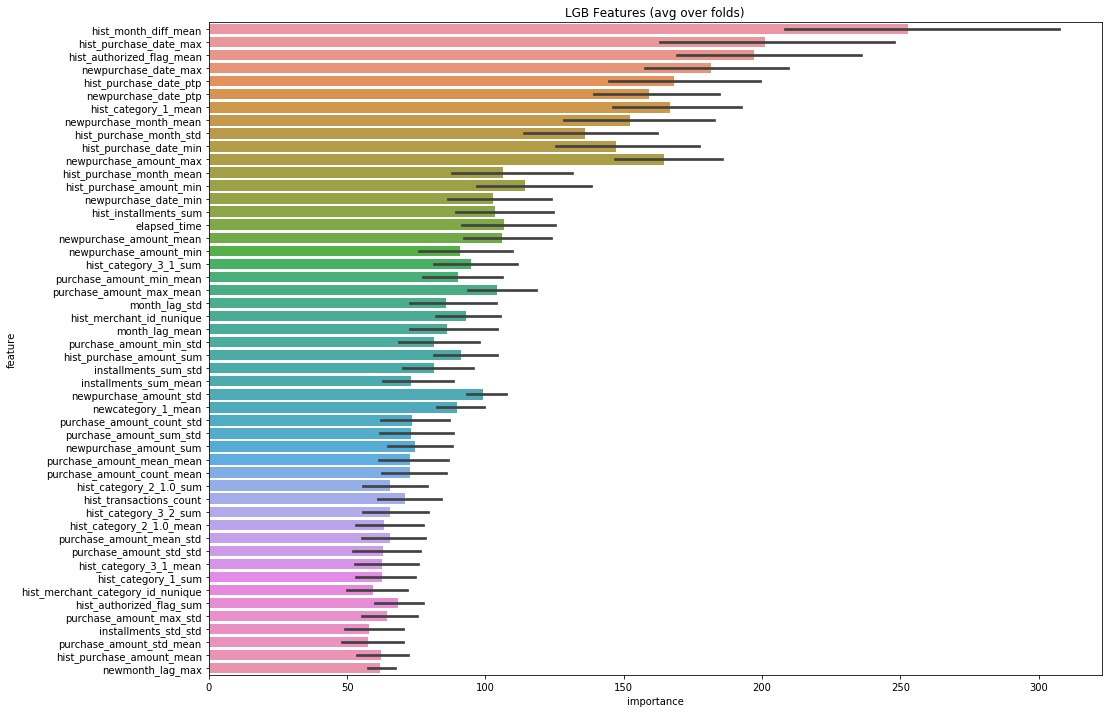

In [18]:
# does not consider new_merchant_transaction  or merchant data
# CV mean score: 3.7437, std: 0.0589, 'max_depth': 18, 'learning_rate': 0.018545526395058548, n_fold = 5
# CV mean score: 3.7445, std: 0.0583, 'max_depth': 18, 'learning_rate': 0.03, n_fold = 5
# CV mean score: 3.7436, std: 0.0585, 'max_depth': 12, 'learning_rate': 0.03, n_fold = 5
# CV mean score: 3.7426, std: 0.0575, 'max_depth': 12, 'learning_rate': 0.01, n_fold = 5
# CV mean score: 3.7424, std: 0.0583, 'max_depth': 12, 'learning_rate': 0.005, n_fold = 5
# CV mean score: 3.7405, std: 0.1007, 'max_depth': 12, 'learning_rate': 0.0075, n_fold = 9

# does not consider merchant data
# CV mean score: 3.6572, std: 0.1065, 'max_depth': 12, 'learning_rate': 0.0075, n_fold = 9


oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)


In [19]:
# lgb.csv does not consider new_merchant_transaction  or merchant data
# lgb1.csv does not consider merchant data

submission = pd.read_csv('./input/sample_submission.csv')
submission['target'] = prediction_lgb
submission.to_csv('lgb_last.csv', index=False)


Fold 0 started at Mon Mar  4 00:18:56 2019


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8606131	test: 3.8679103	best: 3.8679103 (0)	total: 267ms	remaining: 17m 46s
1:	learn: 3.8524388	test: 3.8598530	best: 3.8598530 (1)	total: 452ms	remaining: 15m 4s
2:	learn: 3.8443805	test: 3.8526145	best: 3.8526145 (2)	total: 644ms	remaining: 14m 18s
3:	learn: 3.8366991	test: 3.8461055	best: 3.8461055 (3)	total: 839ms	remaining: 13m 58s
4:	learn: 3.8290909	test: 3.8387396	best: 3.8387396 (4)	total: 1.03s	remaining: 13m 43s
5:	learn: 3.8220511	test: 3.8319726	best: 3.8319726 (5)	total: 1.22s	remaining: 13m 33s
6:	learn: 3.8154845	test: 3.8259162	best: 3.8259162 (6)	total: 1.41s	remaining: 13m 22s
7:	learn: 3.8092322	test: 3.8201031	best: 3.8201031 (7)	total: 1.6s	remaining: 13m 18s
8:	learn: 3.8032874	test: 3.8144009	best: 3.8144009 (8)	total: 1.78s	remaining: 13m 9s
9:	learn: 3.7973014	test: 3.8088918	best: 3.8088918 (9)	total: 1.99s	remaining: 13m 12s
10:	learn: 3.7917399	test: 3.8039725	best: 3.8039725 (10)	total: 2.2s	remaining: 13m 18s
11:	learn: 3.7863272	test: 3.79914

92:	learn: 3.6352786	test: 3.6931746	best: 3.6931746 (92)	total: 17.4s	remaining: 12m 13s
93:	learn: 3.6343607	test: 3.6928422	best: 3.6928422 (93)	total: 17.7s	remaining: 12m 13s
94:	learn: 3.6339291	test: 3.6926051	best: 3.6926051 (94)	total: 17.8s	remaining: 12m 12s
95:	learn: 3.6333477	test: 3.6922985	best: 3.6922985 (95)	total: 18s	remaining: 12m 12s
96:	learn: 3.6326712	test: 3.6921400	best: 3.6921400 (96)	total: 18.2s	remaining: 12m 10s
97:	learn: 3.6317256	test: 3.6917672	best: 3.6917672 (97)	total: 18.3s	remaining: 12m 10s
98:	learn: 3.6310134	test: 3.6915608	best: 3.6915608 (98)	total: 18.5s	remaining: 12m 9s
99:	learn: 3.6304405	test: 3.6913571	best: 3.6913571 (99)	total: 18.7s	remaining: 12m 9s
100:	learn: 3.6298335	test: 3.6911189	best: 3.6911189 (100)	total: 18.9s	remaining: 12m 8s
101:	learn: 3.6293714	test: 3.6910619	best: 3.6910619 (101)	total: 19.1s	remaining: 12m 8s
102:	learn: 3.6287548	test: 3.6906578	best: 3.6906578 (102)	total: 19.2s	remaining: 12m 7s
103:	learn:

182:	learn: 3.5888784	test: 3.6806873	best: 3.6806873 (182)	total: 33.6s	remaining: 11m 39s
183:	learn: 3.5883027	test: 3.6806268	best: 3.6806268 (183)	total: 33.7s	remaining: 11m 39s
184:	learn: 3.5878903	test: 3.6803967	best: 3.6803967 (184)	total: 33.9s	remaining: 11m 39s
185:	learn: 3.5874751	test: 3.6804028	best: 3.6803967 (184)	total: 34.1s	remaining: 11m 38s
186:	learn: 3.5870654	test: 3.6802920	best: 3.6802920 (186)	total: 34.2s	remaining: 11m 38s
187:	learn: 3.5867333	test: 3.6804085	best: 3.6802920 (186)	total: 34.4s	remaining: 11m 37s
188:	learn: 3.5864537	test: 3.6803898	best: 3.6802920 (186)	total: 34.6s	remaining: 11m 37s
189:	learn: 3.5861230	test: 3.6803298	best: 3.6802920 (186)	total: 34.8s	remaining: 11m 37s
190:	learn: 3.5858762	test: 3.6802747	best: 3.6802747 (190)	total: 34.9s	remaining: 11m 36s
191:	learn: 3.5852292	test: 3.6800202	best: 3.6800202 (191)	total: 35.1s	remaining: 11m 36s
192:	learn: 3.5847694	test: 3.6799811	best: 3.6799811 (192)	total: 35.3s	remaini

273:	learn: 3.5548226	test: 3.6770138	best: 3.6770138 (273)	total: 49.3s	remaining: 11m 10s
274:	learn: 3.5545279	test: 3.6771082	best: 3.6770138 (273)	total: 49.5s	remaining: 11m 9s
275:	learn: 3.5540308	test: 3.6770098	best: 3.6770098 (275)	total: 49.6s	remaining: 11m 9s
276:	learn: 3.5537231	test: 3.6770238	best: 3.6770098 (275)	total: 49.8s	remaining: 11m 9s
277:	learn: 3.5534950	test: 3.6770349	best: 3.6770098 (275)	total: 50s	remaining: 11m 9s
278:	learn: 3.5532513	test: 3.6770117	best: 3.6770098 (275)	total: 50.2s	remaining: 11m 9s
279:	learn: 3.5531258	test: 3.6769997	best: 3.6769997 (279)	total: 50.3s	remaining: 11m 8s
280:	learn: 3.5529375	test: 3.6769718	best: 3.6769718 (280)	total: 50.5s	remaining: 11m 8s
281:	learn: 3.5525578	test: 3.6769658	best: 3.6769658 (281)	total: 50.7s	remaining: 11m 8s
282:	learn: 3.5524578	test: 3.6769623	best: 3.6769623 (282)	total: 50.9s	remaining: 11m 8s
283:	learn: 3.5521884	test: 3.6770047	best: 3.6769623 (282)	total: 51.1s	remaining: 11m 8s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8666074	test: 3.8224612	best: 3.8224612 (0)	total: 213ms	remaining: 14m 9s
1:	learn: 3.8580386	test: 3.8145771	best: 3.8145771 (1)	total: 413ms	remaining: 13m 44s
2:	learn: 3.8501717	test: 3.8071744	best: 3.8071744 (2)	total: 610ms	remaining: 13m 33s
3:	learn: 3.8430172	test: 3.8000562	best: 3.8000562 (3)	total: 833ms	remaining: 13m 52s
4:	learn: 3.8357608	test: 3.7931700	best: 3.7931700 (4)	total: 1.01s	remaining: 13m 26s
5:	learn: 3.8286266	test: 3.7860829	best: 3.7860829 (5)	total: 1.19s	remaining: 13m 13s
6:	learn: 3.8223633	test: 3.7799337	best: 3.7799337 (6)	total: 1.38s	remaining: 13m 7s
7:	learn: 3.8156811	test: 3.7735790	best: 3.7735790 (7)	total: 1.56s	remaining: 13m
8:	learn: 3.8094557	test: 3.7677394	best: 3.7677394 (8)	total: 1.74s	remaining: 12m 53s
9:	learn: 3.8040043	test: 3.7621984	best: 3.7621984 (9)	total: 1.96s	remaining: 13m
10:	learn: 3.7983769	test: 3.7568525	best: 3.7568525 (10)	total: 2.15s	remaining: 13m 1s
11:	learn: 3.7935733	test: 3.7524997	best

93:	learn: 3.6455496	test: 3.6402922	best: 3.6402922 (93)	total: 17.6s	remaining: 12m 10s
94:	learn: 3.6446908	test: 3.6401914	best: 3.6401914 (94)	total: 17.7s	remaining: 12m 9s
95:	learn: 3.6440691	test: 3.6400614	best: 3.6400614 (95)	total: 17.9s	remaining: 12m 8s
96:	learn: 3.6431916	test: 3.6396414	best: 3.6396414 (96)	total: 18.1s	remaining: 12m 7s
97:	learn: 3.6423471	test: 3.6391217	best: 3.6391217 (97)	total: 18.3s	remaining: 12m 7s
98:	learn: 3.6415862	test: 3.6385895	best: 3.6385895 (98)	total: 18.4s	remaining: 12m 6s
99:	learn: 3.6407947	test: 3.6382780	best: 3.6382780 (99)	total: 18.6s	remaining: 12m 6s
100:	learn: 3.6403845	test: 3.6381515	best: 3.6381515 (100)	total: 18.8s	remaining: 12m 4s
101:	learn: 3.6395915	test: 3.6377627	best: 3.6377627 (101)	total: 18.9s	remaining: 12m 4s
102:	learn: 3.6388281	test: 3.6375571	best: 3.6375571 (102)	total: 19.1s	remaining: 12m 3s
103:	learn: 3.6381216	test: 3.6372735	best: 3.6372735 (103)	total: 19.3s	remaining: 12m 3s
104:	learn: 

183:	learn: 3.5993737	test: 3.6256800	best: 3.6256800 (183)	total: 33.2s	remaining: 11m 27s
184:	learn: 3.5989932	test: 3.6256711	best: 3.6256711 (184)	total: 33.3s	remaining: 11m 27s
185:	learn: 3.5986070	test: 3.6255966	best: 3.6255966 (185)	total: 33.5s	remaining: 11m 26s
186:	learn: 3.5981692	test: 3.6253556	best: 3.6253556 (186)	total: 33.7s	remaining: 11m 26s
187:	learn: 3.5977723	test: 3.6251302	best: 3.6251302 (187)	total: 33.8s	remaining: 11m 26s
188:	learn: 3.5974812	test: 3.6250709	best: 3.6250709 (188)	total: 34s	remaining: 11m 25s
189:	learn: 3.5972650	test: 3.6249549	best: 3.6249549 (189)	total: 34.2s	remaining: 11m 24s
190:	learn: 3.5969554	test: 3.6247193	best: 3.6247193 (190)	total: 34.3s	remaining: 11m 24s
191:	learn: 3.5964699	test: 3.6244806	best: 3.6244806 (191)	total: 34.5s	remaining: 11m 23s
192:	learn: 3.5959915	test: 3.6243991	best: 3.6243991 (192)	total: 34.6s	remaining: 11m 23s
193:	learn: 3.5954967	test: 3.6242265	best: 3.6242265 (193)	total: 34.8s	remaining

274:	learn: 3.5672443	test: 3.6181364	best: 3.6181364 (274)	total: 48.4s	remaining: 10m 55s
275:	learn: 3.5668392	test: 3.6182088	best: 3.6181364 (274)	total: 48.6s	remaining: 10m 55s
276:	learn: 3.5664265	test: 3.6180616	best: 3.6180616 (276)	total: 48.8s	remaining: 10m 55s
277:	learn: 3.5661206	test: 3.6179839	best: 3.6179839 (277)	total: 48.9s	remaining: 10m 55s
278:	learn: 3.5657401	test: 3.6179653	best: 3.6179653 (278)	total: 49.1s	remaining: 10m 54s
279:	learn: 3.5653542	test: 3.6178866	best: 3.6178866 (279)	total: 49.3s	remaining: 10m 54s
280:	learn: 3.5648888	test: 3.6177954	best: 3.6177954 (280)	total: 49.4s	remaining: 10m 54s
281:	learn: 3.5645089	test: 3.6177022	best: 3.6177022 (281)	total: 49.6s	remaining: 10m 54s
282:	learn: 3.5642500	test: 3.6176349	best: 3.6176349 (282)	total: 49.8s	remaining: 10m 53s
283:	learn: 3.5637786	test: 3.6172330	best: 3.6172330 (283)	total: 50s	remaining: 10m 53s
284:	learn: 3.5633246	test: 3.6172112	best: 3.6172112 (284)	total: 50.1s	remaining

364:	learn: 3.5375603	test: 3.6141519	best: 3.6140994 (355)	total: 1m 3s	remaining: 10m 31s
365:	learn: 3.5372918	test: 3.6141596	best: 3.6140994 (355)	total: 1m 3s	remaining: 10m 30s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.614099442
bestIteration = 355

Shrink model to first 356 iterations.
Fold 2 started at Mon Mar  4 00:21:27 2019


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8377491	test: 4.0500938	best: 4.0500938 (0)	total: 219ms	remaining: 14m 35s
1:	learn: 3.8294121	test: 4.0429381	best: 4.0429381 (1)	total: 393ms	remaining: 13m 5s
2:	learn: 3.8214517	test: 4.0361111	best: 4.0361111 (2)	total: 581ms	remaining: 12m 54s
3:	learn: 3.8130928	test: 4.0289495	best: 4.0289495 (3)	total: 763ms	remaining: 12m 42s
4:	learn: 3.8062926	test: 4.0234237	best: 4.0234237 (4)	total: 952ms	remaining: 12m 41s
5:	learn: 3.7993539	test: 4.0177073	best: 4.0177073 (5)	total: 1.14s	remaining: 12m 40s
6:	learn: 3.7926324	test: 4.0124096	best: 4.0124096 (6)	total: 1.33s	remaining: 12m 40s
7:	learn: 3.7862651	test: 4.0073948	best: 4.0073948 (7)	total: 1.53s	remaining: 12m 42s
8:	learn: 3.7799465	test: 4.0024387	best: 4.0024387 (8)	total: 1.72s	remaining: 12m 42s
9:	learn: 3.7734629	test: 3.9970256	best: 3.9970256 (9)	total: 1.9s	remaining: 12m 38s
10:	learn: 3.7678007	test: 3.9926895	best: 3.9926895 (10)	total: 2.1s	remaining: 12m 40s
11:	learn: 3.7625555	test: 3.9886

93:	learn: 3.6105833	test: 3.8886460	best: 3.8886460 (93)	total: 17.3s	remaining: 11m 57s
94:	learn: 3.6098168	test: 3.8882546	best: 3.8882546 (94)	total: 17.4s	remaining: 11m 56s
95:	learn: 3.6090878	test: 3.8880337	best: 3.8880337 (95)	total: 17.6s	remaining: 11m 56s
96:	learn: 3.6085167	test: 3.8876905	best: 3.8876905 (96)	total: 17.8s	remaining: 11m 55s
97:	learn: 3.6076145	test: 3.8874404	best: 3.8874404 (97)	total: 18s	remaining: 11m 55s
98:	learn: 3.6068416	test: 3.8871039	best: 3.8871039 (98)	total: 18.1s	remaining: 11m 54s
99:	learn: 3.6063037	test: 3.8868370	best: 3.8868370 (99)	total: 18.3s	remaining: 11m 54s
100:	learn: 3.6059324	test: 3.8866159	best: 3.8866159 (100)	total: 18.5s	remaining: 11m 53s
101:	learn: 3.6053420	test: 3.8863461	best: 3.8863461 (101)	total: 18.6s	remaining: 11m 52s
102:	learn: 3.6046142	test: 3.8860910	best: 3.8860910 (102)	total: 18.8s	remaining: 11m 51s
103:	learn: 3.6041492	test: 3.8860277	best: 3.8860277 (103)	total: 19s	remaining: 11m 50s
104:	l

183:	learn: 3.5635186	test: 3.8763365	best: 3.8763365 (183)	total: 32.8s	remaining: 11m 19s
184:	learn: 3.5631674	test: 3.8762863	best: 3.8762863 (184)	total: 32.9s	remaining: 11m 19s
185:	learn: 3.5628827	test: 3.8761901	best: 3.8761901 (185)	total: 33.1s	remaining: 11m 19s
186:	learn: 3.5623987	test: 3.8761852	best: 3.8761852 (186)	total: 33.3s	remaining: 11m 18s
187:	learn: 3.5621405	test: 3.8760895	best: 3.8760895 (187)	total: 33.5s	remaining: 11m 18s
188:	learn: 3.5619306	test: 3.8760808	best: 3.8760808 (188)	total: 33.6s	remaining: 11m 17s
189:	learn: 3.5613464	test: 3.8759847	best: 3.8759847 (189)	total: 33.8s	remaining: 11m 17s
190:	learn: 3.5607454	test: 3.8759526	best: 3.8759526 (190)	total: 34s	remaining: 11m 17s
191:	learn: 3.5604383	test: 3.8758050	best: 3.8758050 (191)	total: 34.1s	remaining: 11m 16s
192:	learn: 3.5597788	test: 3.8757118	best: 3.8757118 (192)	total: 34.3s	remaining: 11m 16s
193:	learn: 3.5593725	test: 3.8755111	best: 3.8755111 (193)	total: 34.5s	remaining

274:	learn: 3.5298627	test: 3.8710826	best: 3.8710429 (271)	total: 48.1s	remaining: 10m 51s
275:	learn: 3.5297749	test: 3.8710831	best: 3.8710429 (271)	total: 48.3s	remaining: 10m 51s
276:	learn: 3.5295503	test: 3.8710368	best: 3.8710368 (276)	total: 48.5s	remaining: 10m 51s
277:	learn: 3.5292151	test: 3.8710007	best: 3.8710007 (277)	total: 48.6s	remaining: 10m 51s
278:	learn: 3.5288495	test: 3.8710032	best: 3.8710007 (277)	total: 48.8s	remaining: 10m 51s
279:	learn: 3.5285667	test: 3.8709724	best: 3.8709724 (279)	total: 49s	remaining: 10m 50s
280:	learn: 3.5282332	test: 3.8708526	best: 3.8708526 (280)	total: 49.1s	remaining: 10m 50s
281:	learn: 3.5278316	test: 3.8707802	best: 3.8707802 (281)	total: 49.3s	remaining: 10m 50s
282:	learn: 3.5276253	test: 3.8707563	best: 3.8707563 (282)	total: 49.5s	remaining: 10m 50s
283:	learn: 3.5271836	test: 3.8707562	best: 3.8707562 (283)	total: 49.7s	remaining: 10m 49s
284:	learn: 3.5266469	test: 3.8706879	best: 3.8706879 (284)	total: 49.8s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8476651	test: 3.9721649	best: 3.9721649 (0)	total: 215ms	remaining: 14m 18s
1:	learn: 3.8390854	test: 3.9642682	best: 3.9642682 (1)	total: 397ms	remaining: 13m 12s
2:	learn: 3.8312014	test: 3.9573329	best: 3.9573329 (2)	total: 607ms	remaining: 13m 29s
3:	learn: 3.8237338	test: 3.9506953	best: 3.9506953 (3)	total: 810ms	remaining: 13m 29s
4:	learn: 3.8164185	test: 3.9440150	best: 3.9440150 (4)	total: 1.01s	remaining: 13m 26s
5:	learn: 3.8096434	test: 3.9377290	best: 3.9377290 (5)	total: 1.21s	remaining: 13m 27s
6:	learn: 3.8031335	test: 3.9318622	best: 3.9318622 (6)	total: 1.41s	remaining: 13m 24s
7:	learn: 3.7968643	test: 3.9262090	best: 3.9262090 (7)	total: 1.61s	remaining: 13m 24s
8:	learn: 3.7914468	test: 3.9213650	best: 3.9213650 (8)	total: 1.78s	remaining: 13m 8s
9:	learn: 3.7854828	test: 3.9154778	best: 3.9154778 (9)	total: 1.96s	remaining: 13m
10:	learn: 3.7798957	test: 3.9107359	best: 3.9107359 (10)	total: 2.14s	remaining: 12m 56s
11:	learn: 3.7741800	test: 3.905756

93:	learn: 3.6266578	test: 3.7887099	best: 3.7887099 (93)	total: 17.3s	remaining: 11m 59s
94:	learn: 3.6259115	test: 3.7883710	best: 3.7883710 (94)	total: 17.5s	remaining: 11m 59s
95:	learn: 3.6252648	test: 3.7880158	best: 3.7880158 (95)	total: 17.7s	remaining: 11m 59s
96:	learn: 3.6244554	test: 3.7877048	best: 3.7877048 (96)	total: 17.9s	remaining: 11m 58s
97:	learn: 3.6238653	test: 3.7875944	best: 3.7875944 (97)	total: 18s	remaining: 11m 57s
98:	learn: 3.6231561	test: 3.7872278	best: 3.7872278 (98)	total: 18.2s	remaining: 11m 57s
99:	learn: 3.6226191	test: 3.7869532	best: 3.7869532 (99)	total: 18.4s	remaining: 11m 57s
100:	learn: 3.6220815	test: 3.7866484	best: 3.7866484 (100)	total: 18.6s	remaining: 11m 56s
101:	learn: 3.6216545	test: 3.7862950	best: 3.7862950 (101)	total: 18.7s	remaining: 11m 55s
102:	learn: 3.6208337	test: 3.7858367	best: 3.7858367 (102)	total: 18.9s	remaining: 11m 55s
103:	learn: 3.6201126	test: 3.7857326	best: 3.7857326 (103)	total: 19.1s	remaining: 11m 55s
104:

183:	learn: 3.5799812	test: 3.7713656	best: 3.7713656 (183)	total: 33.1s	remaining: 11m 25s
184:	learn: 3.5794807	test: 3.7712229	best: 3.7712229 (184)	total: 33.2s	remaining: 11m 25s
185:	learn: 3.5792982	test: 3.7711421	best: 3.7711421 (185)	total: 33.4s	remaining: 11m 24s
186:	learn: 3.5788642	test: 3.7708829	best: 3.7708829 (186)	total: 33.6s	remaining: 11m 24s
187:	learn: 3.5785836	test: 3.7708487	best: 3.7708487 (187)	total: 33.7s	remaining: 11m 23s
188:	learn: 3.5781580	test: 3.7707995	best: 3.7707995 (188)	total: 33.9s	remaining: 11m 23s
189:	learn: 3.5778906	test: 3.7707005	best: 3.7707005 (189)	total: 34.1s	remaining: 11m 23s
190:	learn: 3.5775668	test: 3.7705514	best: 3.7705514 (190)	total: 34.2s	remaining: 11m 22s
191:	learn: 3.5771886	test: 3.7704028	best: 3.7704028 (191)	total: 34.4s	remaining: 11m 22s
192:	learn: 3.5766843	test: 3.7703419	best: 3.7703419 (192)	total: 34.6s	remaining: 11m 21s
193:	learn: 3.5760632	test: 3.7701843	best: 3.7701843 (193)	total: 34.7s	remaini

274:	learn: 3.5450564	test: 3.7650289	best: 3.7650289 (274)	total: 48.4s	remaining: 10m 55s
275:	learn: 3.5447057	test: 3.7646301	best: 3.7646301 (275)	total: 48.5s	remaining: 10m 55s
276:	learn: 3.5445758	test: 3.7646406	best: 3.7646301 (275)	total: 48.7s	remaining: 10m 54s
277:	learn: 3.5441755	test: 3.7645199	best: 3.7645199 (277)	total: 48.9s	remaining: 10m 54s
278:	learn: 3.5437606	test: 3.7645243	best: 3.7645199 (277)	total: 49.1s	remaining: 10m 54s
279:	learn: 3.5433068	test: 3.7646250	best: 3.7645199 (277)	total: 49.2s	remaining: 10m 54s
280:	learn: 3.5428384	test: 3.7642281	best: 3.7642281 (280)	total: 49.4s	remaining: 10m 54s
281:	learn: 3.5425615	test: 3.7642936	best: 3.7642281 (280)	total: 49.6s	remaining: 10m 53s
282:	learn: 3.5419731	test: 3.7640759	best: 3.7640759 (282)	total: 49.8s	remaining: 10m 53s
283:	learn: 3.5415694	test: 3.7640224	best: 3.7640224 (283)	total: 49.9s	remaining: 10m 53s
284:	learn: 3.5412925	test: 3.7640299	best: 3.7640224 (283)	total: 50.1s	remaini

365:	learn: 3.5144384	test: 3.7598851	best: 3.7598851 (365)	total: 1m 3s	remaining: 10m 34s
366:	learn: 3.5141460	test: 3.7598546	best: 3.7598546 (366)	total: 1m 4s	remaining: 10m 33s
367:	learn: 3.5138131	test: 3.7597401	best: 3.7597401 (367)	total: 1m 4s	remaining: 10m 33s
368:	learn: 3.5135622	test: 3.7596451	best: 3.7596451 (368)	total: 1m 4s	remaining: 10m 33s
369:	learn: 3.5133031	test: 3.7597164	best: 3.7596451 (368)	total: 1m 4s	remaining: 10m 33s
370:	learn: 3.5130177	test: 3.7597564	best: 3.7596451 (368)	total: 1m 4s	remaining: 10m 32s
371:	learn: 3.5123273	test: 3.7598756	best: 3.7596451 (368)	total: 1m 4s	remaining: 10m 32s
372:	learn: 3.5120818	test: 3.7598588	best: 3.7596451 (368)	total: 1m 5s	remaining: 10m 32s
373:	learn: 3.5116190	test: 3.7598511	best: 3.7596451 (368)	total: 1m 5s	remaining: 10m 32s
374:	learn: 3.5112897	test: 3.7598335	best: 3.7596451 (368)	total: 1m 5s	remaining: 10m 32s
375:	learn: 3.5110254	test: 3.7598118	best: 3.7596451 (368)	total: 1m 5s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8678869	test: 3.8147219	best: 3.8147219 (0)	total: 221ms	remaining: 14m 44s
1:	learn: 3.8598127	test: 3.8060630	best: 3.8060630 (1)	total: 394ms	remaining: 13m 7s
2:	learn: 3.8517802	test: 3.7979247	best: 3.7979247 (2)	total: 587ms	remaining: 13m 1s
3:	learn: 3.8436855	test: 3.7891426	best: 3.7891426 (3)	total: 769ms	remaining: 12m 48s
4:	learn: 3.8366356	test: 3.7816713	best: 3.7816713 (4)	total: 954ms	remaining: 12m 42s
5:	learn: 3.8296077	test: 3.7745623	best: 3.7745623 (5)	total: 1.15s	remaining: 12m 43s
6:	learn: 3.8228752	test: 3.7679603	best: 3.7679603 (6)	total: 1.34s	remaining: 12m 46s
7:	learn: 3.8170364	test: 3.7616765	best: 3.7616765 (7)	total: 1.54s	remaining: 12m 49s
8:	learn: 3.8113069	test: 3.7551532	best: 3.7551532 (8)	total: 1.74s	remaining: 12m 49s
9:	learn: 3.8054735	test: 3.7488568	best: 3.7488568 (9)	total: 1.92s	remaining: 12m 44s
10:	learn: 3.8000967	test: 3.7433578	best: 3.7433578 (10)	total: 2.1s	remaining: 12m 43s
11:	learn: 3.7948487	test: 3.7377

92:	learn: 3.6512339	test: 3.6074970	best: 3.6074735 (91)	total: 17.1s	remaining: 11m 58s
93:	learn: 3.6504876	test: 3.6069199	best: 3.6069199 (93)	total: 17.3s	remaining: 11m 58s
94:	learn: 3.6500332	test: 3.6064792	best: 3.6064792 (94)	total: 17.4s	remaining: 11m 56s
95:	learn: 3.6494579	test: 3.6061405	best: 3.6061405 (95)	total: 17.6s	remaining: 11m 56s
96:	learn: 3.6488476	test: 3.6053273	best: 3.6053273 (96)	total: 17.8s	remaining: 11m 56s
97:	learn: 3.6481521	test: 3.6050548	best: 3.6050548 (97)	total: 18s	remaining: 11m 55s
98:	learn: 3.6471858	test: 3.6046566	best: 3.6046566 (98)	total: 18.2s	remaining: 11m 55s
99:	learn: 3.6463524	test: 3.6037654	best: 3.6037654 (99)	total: 18.3s	remaining: 11m 55s
100:	learn: 3.6458565	test: 3.6036777	best: 3.6036777 (100)	total: 18.5s	remaining: 11m 54s
101:	learn: 3.6452741	test: 3.6034159	best: 3.6034159 (101)	total: 18.7s	remaining: 11m 54s
102:	learn: 3.6445327	test: 3.6028925	best: 3.6028925 (102)	total: 18.9s	remaining: 11m 53s
103:	l

183:	learn: 3.6062709	test: 3.5873854	best: 3.5873854 (183)	total: 32.6s	remaining: 11m 15s
184:	learn: 3.6057950	test: 3.5873673	best: 3.5873673 (184)	total: 32.8s	remaining: 11m 15s
185:	learn: 3.6053931	test: 3.5871930	best: 3.5871930 (185)	total: 32.9s	remaining: 11m 15s
186:	learn: 3.6049885	test: 3.5870514	best: 3.5870514 (186)	total: 33.1s	remaining: 11m 14s
187:	learn: 3.6047415	test: 3.5869463	best: 3.5869463 (187)	total: 33.3s	remaining: 11m 14s
188:	learn: 3.6043557	test: 3.5869187	best: 3.5869187 (188)	total: 33.4s	remaining: 11m 14s
189:	learn: 3.6041298	test: 3.5867362	best: 3.5867362 (189)	total: 33.6s	remaining: 11m 13s
190:	learn: 3.6034783	test: 3.5865659	best: 3.5865659 (190)	total: 33.8s	remaining: 11m 13s
191:	learn: 3.6031133	test: 3.5865701	best: 3.5865659 (190)	total: 33.9s	remaining: 11m 13s
192:	learn: 3.6026749	test: 3.5865322	best: 3.5865322 (192)	total: 34.1s	remaining: 11m 12s
193:	learn: 3.6022596	test: 3.5863849	best: 3.5863849 (193)	total: 34.3s	remaini

273:	learn: 3.5723092	test: 3.5799681	best: 3.5799681 (273)	total: 47.8s	remaining: 10m 49s
274:	learn: 3.5720409	test: 3.5799990	best: 3.5799681 (273)	total: 47.9s	remaining: 10m 49s
275:	learn: 3.5717913	test: 3.5799691	best: 3.5799681 (273)	total: 48.1s	remaining: 10m 49s
276:	learn: 3.5715479	test: 3.5799105	best: 3.5799105 (276)	total: 48.3s	remaining: 10m 48s
277:	learn: 3.5710790	test: 3.5798452	best: 3.5798452 (277)	total: 48.4s	remaining: 10m 48s
278:	learn: 3.5706181	test: 3.5798495	best: 3.5798452 (277)	total: 48.6s	remaining: 10m 48s
279:	learn: 3.5704152	test: 3.5798628	best: 3.5798452 (277)	total: 48.8s	remaining: 10m 47s
280:	learn: 3.5703692	test: 3.5798481	best: 3.5798452 (277)	total: 48.9s	remaining: 10m 47s
281:	learn: 3.5700812	test: 3.5799085	best: 3.5798452 (277)	total: 49.1s	remaining: 10m 47s
282:	learn: 3.5695606	test: 3.5796990	best: 3.5796990 (282)	total: 49.3s	remaining: 10m 46s
283:	learn: 3.5691368	test: 3.5796338	best: 3.5796338 (283)	total: 49.4s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8813677	test: 3.7025604	best: 3.7025604 (0)	total: 214ms	remaining: 14m 17s
1:	learn: 3.8728136	test: 3.6944067	best: 3.6944067 (1)	total: 401ms	remaining: 13m 21s
2:	learn: 3.8648379	test: 3.6868091	best: 3.6868091 (2)	total: 592ms	remaining: 13m 9s
3:	learn: 3.8567908	test: 3.6791316	best: 3.6791316 (3)	total: 782ms	remaining: 13m 1s
4:	learn: 3.8499667	test: 3.6728263	best: 3.6728263 (4)	total: 956ms	remaining: 12m 43s
5:	learn: 3.8428177	test: 3.6662973	best: 3.6662973 (5)	total: 1.14s	remaining: 12m 41s
6:	learn: 3.8360318	test: 3.6603138	best: 3.6603138 (6)	total: 1.32s	remaining: 12m 35s
7:	learn: 3.8295870	test: 3.6541988	best: 3.6541988 (7)	total: 1.52s	remaining: 12m 38s
8:	learn: 3.8233457	test: 3.6484302	best: 3.6484302 (8)	total: 1.71s	remaining: 12m 37s
9:	learn: 3.8173557	test: 3.6428419	best: 3.6428419 (9)	total: 1.9s	remaining: 12m 38s
10:	learn: 3.8120695	test: 3.6385960	best: 3.6385960 (10)	total: 2.09s	remaining: 12m 38s
11:	learn: 3.8067438	test: 3.6338

92:	learn: 3.6554029	test: 3.5336362	best: 3.5336362 (92)	total: 16.9s	remaining: 11m 51s
93:	learn: 3.6549019	test: 3.5334991	best: 3.5334991 (93)	total: 17.1s	remaining: 11m 50s
94:	learn: 3.6537823	test: 3.5334015	best: 3.5334015 (94)	total: 17.3s	remaining: 11m 50s
95:	learn: 3.6530911	test: 3.5330767	best: 3.5330767 (95)	total: 17.5s	remaining: 11m 50s
96:	learn: 3.6526426	test: 3.5329882	best: 3.5329882 (96)	total: 17.6s	remaining: 11m 49s
97:	learn: 3.6519707	test: 3.5326843	best: 3.5326843 (97)	total: 17.8s	remaining: 11m 48s
98:	learn: 3.6507776	test: 3.5327202	best: 3.5326843 (97)	total: 18s	remaining: 11m 48s
99:	learn: 3.6501598	test: 3.5324219	best: 3.5324219 (99)	total: 18.2s	remaining: 11m 48s
100:	learn: 3.6497393	test: 3.5322491	best: 3.5322491 (100)	total: 18.3s	remaining: 11m 47s
101:	learn: 3.6493988	test: 3.5319827	best: 3.5319827 (101)	total: 18.5s	remaining: 11m 47s
102:	learn: 3.6487853	test: 3.5318033	best: 3.5318033 (102)	total: 18.7s	remaining: 11m 46s
103:	l

182:	learn: 3.6074752	test: 3.5224183	best: 3.5223509 (179)	total: 32.4s	remaining: 11m 15s
183:	learn: 3.6069510	test: 3.5223744	best: 3.5223509 (179)	total: 32.5s	remaining: 11m 14s
184:	learn: 3.6062559	test: 3.5220975	best: 3.5220975 (184)	total: 32.7s	remaining: 11m 14s
185:	learn: 3.6058621	test: 3.5220019	best: 3.5220019 (185)	total: 32.9s	remaining: 11m 14s
186:	learn: 3.6055204	test: 3.5220202	best: 3.5220019 (185)	total: 33s	remaining: 11m 13s
187:	learn: 3.6052623	test: 3.5220021	best: 3.5220019 (185)	total: 33.2s	remaining: 11m 13s
188:	learn: 3.6047295	test: 3.5218481	best: 3.5218481 (188)	total: 33.4s	remaining: 11m 12s
189:	learn: 3.6040751	test: 3.5218035	best: 3.5218035 (189)	total: 33.6s	remaining: 11m 12s
190:	learn: 3.6036402	test: 3.5217854	best: 3.5217854 (190)	total: 33.8s	remaining: 11m 13s
191:	learn: 3.6032119	test: 3.5216787	best: 3.5216787 (191)	total: 34s	remaining: 11m 13s
192:	learn: 3.6028557	test: 3.5215861	best: 3.5215861 (192)	total: 34.2s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8642973	test: 3.8376322	best: 3.8376322 (0)	total: 205ms	remaining: 13m 40s
1:	learn: 3.8563206	test: 3.8305494	best: 3.8305494 (1)	total: 397ms	remaining: 13m 14s
2:	learn: 3.8485811	test: 3.8238424	best: 3.8238424 (2)	total: 590ms	remaining: 13m 5s
3:	learn: 3.8401581	test: 3.8163338	best: 3.8163338 (3)	total: 776ms	remaining: 12m 55s
4:	learn: 3.8332910	test: 3.8105698	best: 3.8105698 (4)	total: 958ms	remaining: 12m 45s
5:	learn: 3.8263882	test: 3.8046662	best: 3.8046662 (5)	total: 1.15s	remaining: 12m 47s
6:	learn: 3.8191269	test: 3.7986196	best: 3.7986196 (6)	total: 1.34s	remaining: 12m 47s
7:	learn: 3.8127967	test: 3.7931708	best: 3.7931708 (7)	total: 1.54s	remaining: 12m 49s
8:	learn: 3.8064069	test: 3.7878772	best: 3.7878772 (8)	total: 1.73s	remaining: 12m 46s
9:	learn: 3.8009223	test: 3.7832294	best: 3.7832294 (9)	total: 1.9s	remaining: 12m 36s
10:	learn: 3.7954654	test: 3.7787862	best: 3.7787862 (10)	total: 2.09s	remaining: 12m 37s
11:	learn: 3.7898891	test: 3.774

92:	learn: 3.6410493	test: 3.6706529	best: 3.6706529 (92)	total: 17.3s	remaining: 12m 6s
93:	learn: 3.6401045	test: 3.6700722	best: 3.6700722 (93)	total: 17.5s	remaining: 12m 5s
94:	learn: 3.6394797	test: 3.6699271	best: 3.6699271 (94)	total: 17.7s	remaining: 12m 5s
95:	learn: 3.6386374	test: 3.6695979	best: 3.6695979 (95)	total: 17.8s	remaining: 12m 5s
96:	learn: 3.6379651	test: 3.6694078	best: 3.6694078 (96)	total: 18s	remaining: 12m 5s
97:	learn: 3.6371235	test: 3.6690662	best: 3.6690662 (97)	total: 18.2s	remaining: 12m 4s
98:	learn: 3.6365607	test: 3.6686346	best: 3.6686346 (98)	total: 18.4s	remaining: 12m 4s
99:	learn: 3.6358471	test: 3.6682824	best: 3.6682824 (99)	total: 18.6s	remaining: 12m 4s
100:	learn: 3.6350300	test: 3.6681162	best: 3.6681162 (100)	total: 18.7s	remaining: 12m 3s
101:	learn: 3.6344676	test: 3.6680699	best: 3.6680699 (101)	total: 18.9s	remaining: 12m 3s
102:	learn: 3.6336360	test: 3.6675918	best: 3.6675918 (102)	total: 19.1s	remaining: 12m 3s
103:	learn: 3.633

183:	learn: 3.5947564	test: 3.6582686	best: 3.6582663 (182)	total: 33.4s	remaining: 11m 31s
184:	learn: 3.5941755	test: 3.6580368	best: 3.6580368 (184)	total: 33.5s	remaining: 11m 31s
185:	learn: 3.5937656	test: 3.6579459	best: 3.6579459 (185)	total: 33.7s	remaining: 11m 31s
186:	learn: 3.5932951	test: 3.6578297	best: 3.6578297 (186)	total: 33.9s	remaining: 11m 31s
187:	learn: 3.5930203	test: 3.6578388	best: 3.6578297 (186)	total: 34.1s	remaining: 11m 31s
188:	learn: 3.5927717	test: 3.6578427	best: 3.6578297 (186)	total: 34.3s	remaining: 11m 30s
189:	learn: 3.5923079	test: 3.6579029	best: 3.6578297 (186)	total: 34.4s	remaining: 11m 30s
190:	learn: 3.5919809	test: 3.6579097	best: 3.6578297 (186)	total: 34.6s	remaining: 11m 30s
191:	learn: 3.5916680	test: 3.6578328	best: 3.6578297 (186)	total: 34.8s	remaining: 11m 30s
192:	learn: 3.5910677	test: 3.6578627	best: 3.6578297 (186)	total: 35s	remaining: 11m 30s
193:	learn: 3.5906928	test: 3.6578509	best: 3.6578297 (186)	total: 35.2s	remaining

273:	learn: 3.5632168	test: 3.6534179	best: 3.6534179 (273)	total: 49.8s	remaining: 11m 16s
274:	learn: 3.5630243	test: 3.6533767	best: 3.6533767 (274)	total: 49.9s	remaining: 11m 16s
275:	learn: 3.5626358	test: 3.6532896	best: 3.6532896 (275)	total: 50.1s	remaining: 11m 16s
276:	learn: 3.5623995	test: 3.6532703	best: 3.6532703 (276)	total: 50.3s	remaining: 11m 15s
277:	learn: 3.5621203	test: 3.6532992	best: 3.6532703 (276)	total: 50.5s	remaining: 11m 15s
278:	learn: 3.5617217	test: 3.6533589	best: 3.6532703 (276)	total: 50.7s	remaining: 11m 15s
279:	learn: 3.5610489	test: 3.6530901	best: 3.6530901 (279)	total: 50.9s	remaining: 11m 15s
280:	learn: 3.5605491	test: 3.6531120	best: 3.6530901 (279)	total: 51.1s	remaining: 11m 15s
281:	learn: 3.5602243	test: 3.6531063	best: 3.6530901 (279)	total: 51.2s	remaining: 11m 15s
282:	learn: 3.5599367	test: 3.6530417	best: 3.6530417 (282)	total: 51.4s	remaining: 11m 15s
283:	learn: 3.5595596	test: 3.6530470	best: 3.6530417 (282)	total: 51.6s	remaini

363:	learn: 3.5329729	test: 3.6492409	best: 3.6492409 (363)	total: 1m 6s	remaining: 10m 59s
364:	learn: 3.5328447	test: 3.6492400	best: 3.6492400 (364)	total: 1m 6s	remaining: 10m 59s
365:	learn: 3.5326963	test: 3.6492095	best: 3.6492095 (365)	total: 1m 6s	remaining: 10m 59s
366:	learn: 3.5324692	test: 3.6491747	best: 3.6491747 (366)	total: 1m 6s	remaining: 10m 58s
367:	learn: 3.5320407	test: 3.6490152	best: 3.6490152 (367)	total: 1m 6s	remaining: 10m 58s
368:	learn: 3.5315289	test: 3.6491481	best: 3.6490152 (367)	total: 1m 6s	remaining: 10m 58s
369:	learn: 3.5311985	test: 3.6490059	best: 3.6490059 (369)	total: 1m 7s	remaining: 10m 58s
370:	learn: 3.5310428	test: 3.6490052	best: 3.6490052 (370)	total: 1m 7s	remaining: 10m 57s
371:	learn: 3.5306903	test: 3.6490317	best: 3.6490052 (370)	total: 1m 7s	remaining: 10m 57s
372:	learn: 3.5306855	test: 3.6490291	best: 3.6490052 (370)	total: 1m 7s	remaining: 10m 57s
373:	learn: 3.5303579	test: 3.6489091	best: 3.6489091 (373)	total: 1m 7s	remaini

453:	learn: 3.5054946	test: 3.6469447	best: 3.6468364 (448)	total: 1m 21s	remaining: 10m 37s
454:	learn: 3.5053336	test: 3.6469388	best: 3.6468364 (448)	total: 1m 21s	remaining: 10m 36s
455:	learn: 3.5048359	test: 3.6468840	best: 3.6468364 (448)	total: 1m 21s	remaining: 10m 36s
456:	learn: 3.5043863	test: 3.6468030	best: 3.6468030 (456)	total: 1m 22s	remaining: 10m 36s
457:	learn: 3.5039641	test: 3.6467783	best: 3.6467783 (457)	total: 1m 22s	remaining: 10m 36s
458:	learn: 3.5039256	test: 3.6467757	best: 3.6467757 (458)	total: 1m 22s	remaining: 10m 35s
459:	learn: 3.5033643	test: 3.6467422	best: 3.6467422 (459)	total: 1m 22s	remaining: 10m 35s
460:	learn: 3.5030725	test: 3.6466851	best: 3.6466851 (460)	total: 1m 22s	remaining: 10m 35s
461:	learn: 3.5024978	test: 3.6466500	best: 3.6466500 (461)	total: 1m 22s	remaining: 10m 35s
462:	learn: 3.5022267	test: 3.6466178	best: 3.6466178 (462)	total: 1m 23s	remaining: 10m 34s
463:	learn: 3.5017133	test: 3.6464944	best: 3.6464944 (463)	total: 1m 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8769099	test: 3.7358428	best: 3.7358428 (0)	total: 216ms	remaining: 14m 24s
1:	learn: 3.8690630	test: 3.7293092	best: 3.7293092 (1)	total: 387ms	remaining: 12m 53s
2:	learn: 3.8610466	test: 3.7225989	best: 3.7225989 (2)	total: 576ms	remaining: 12m 47s
3:	learn: 3.8527002	test: 3.7153378	best: 3.7153378 (3)	total: 758ms	remaining: 12m 36s
4:	learn: 3.8453200	test: 3.7087980	best: 3.7087980 (4)	total: 947ms	remaining: 12m 36s
5:	learn: 3.8385036	test: 3.7027479	best: 3.7027479 (5)	total: 1.14s	remaining: 12m 39s
6:	learn: 3.8317496	test: 3.6971746	best: 3.6971746 (6)	total: 1.34s	remaining: 12m 42s
7:	learn: 3.8253181	test: 3.6912617	best: 3.6912617 (7)	total: 1.51s	remaining: 12m 35s
8:	learn: 3.8188706	test: 3.6856953	best: 3.6856953 (8)	total: 1.71s	remaining: 12m 37s
9:	learn: 3.8133160	test: 3.6810822	best: 3.6810822 (9)	total: 1.9s	remaining: 12m 36s
10:	learn: 3.8077302	test: 3.6765431	best: 3.6765431 (10)	total: 2.08s	remaining: 12m 35s
11:	learn: 3.8025777	test: 3.67

92:	learn: 3.6528625	test: 3.5763390	best: 3.5763390 (92)	total: 16.9s	remaining: 11m 48s
93:	learn: 3.6520916	test: 3.5762157	best: 3.5762157 (93)	total: 17s	remaining: 11m 47s
94:	learn: 3.6510049	test: 3.5760338	best: 3.5760338 (94)	total: 17.2s	remaining: 11m 47s
95:	learn: 3.6504641	test: 3.5759363	best: 3.5759363 (95)	total: 17.4s	remaining: 11m 46s
96:	learn: 3.6499576	test: 3.5758950	best: 3.5758950 (96)	total: 17.5s	remaining: 11m 45s
97:	learn: 3.6491108	test: 3.5756247	best: 3.5756247 (97)	total: 17.7s	remaining: 11m 44s
98:	learn: 3.6484512	test: 3.5751865	best: 3.5751865 (98)	total: 17.9s	remaining: 11m 45s
99:	learn: 3.6479675	test: 3.5750280	best: 3.5750280 (99)	total: 18.1s	remaining: 11m 45s
100:	learn: 3.6471963	test: 3.5747683	best: 3.5747683 (100)	total: 18.2s	remaining: 11m 44s
101:	learn: 3.6464667	test: 3.5745913	best: 3.5745913 (101)	total: 18.4s	remaining: 11m 44s
102:	learn: 3.6458106	test: 3.5743461	best: 3.5743461 (102)	total: 18.6s	remaining: 11m 44s
103:	l

182:	learn: 3.6055151	test: 3.5650651	best: 3.5650496 (179)	total: 32.4s	remaining: 11m 16s
183:	learn: 3.6049985	test: 3.5650300	best: 3.5650300 (183)	total: 32.6s	remaining: 11m 16s
184:	learn: 3.6043506	test: 3.5648526	best: 3.5648526 (184)	total: 32.8s	remaining: 11m 16s
185:	learn: 3.6038421	test: 3.5647623	best: 3.5647623 (185)	total: 33s	remaining: 11m 16s
186:	learn: 3.6033519	test: 3.5647146	best: 3.5647146 (186)	total: 33.1s	remaining: 11m 15s
187:	learn: 3.6028307	test: 3.5647174	best: 3.5647146 (186)	total: 33.3s	remaining: 11m 15s
188:	learn: 3.6025847	test: 3.5647084	best: 3.5647084 (188)	total: 33.5s	remaining: 11m 15s
189:	learn: 3.6023751	test: 3.5647420	best: 3.5647084 (188)	total: 33.6s	remaining: 11m 14s
190:	learn: 3.6019728	test: 3.5647084	best: 3.5647084 (190)	total: 33.8s	remaining: 11m 14s
191:	learn: 3.6015669	test: 3.5647828	best: 3.5647084 (190)	total: 34s	remaining: 11m 13s
192:	learn: 3.6012621	test: 3.5647318	best: 3.5647084 (190)	total: 34.1s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8509277	test: 3.9448329	best: 3.9448329 (0)	total: 214ms	remaining: 14m 17s
1:	learn: 3.8424019	test: 3.9368185	best: 3.9368185 (1)	total: 451ms	remaining: 15m
2:	learn: 3.8346312	test: 3.9297168	best: 3.9297168 (2)	total: 668ms	remaining: 14m 50s
3:	learn: 3.8272176	test: 3.9227215	best: 3.9227215 (3)	total: 846ms	remaining: 14m 5s
4:	learn: 3.8200593	test: 3.9159331	best: 3.9159331 (4)	total: 1.03s	remaining: 13m 44s
5:	learn: 3.8130118	test: 3.9091578	best: 3.9091578 (5)	total: 1.22s	remaining: 13m 29s
6:	learn: 3.8066119	test: 3.9034256	best: 3.9034256 (6)	total: 1.41s	remaining: 13m 21s
7:	learn: 3.8001832	test: 3.8975155	best: 3.8975155 (7)	total: 1.59s	remaining: 13m 16s
8:	learn: 3.7938449	test: 3.8917196	best: 3.8917196 (8)	total: 1.79s	remaining: 13m 13s
9:	learn: 3.7882469	test: 3.8865539	best: 3.8865539 (9)	total: 1.97s	remaining: 13m 7s
10:	learn: 3.7825588	test: 3.8819487	best: 3.8819487 (10)	total: 2.17s	remaining: 13m 6s
11:	learn: 3.7770153	test: 3.8768822	

92:	learn: 3.6291266	test: 3.7668145	best: 3.7668145 (92)	total: 17.4s	remaining: 12m 9s
93:	learn: 3.6284305	test: 3.7666767	best: 3.7666767 (93)	total: 17.5s	remaining: 12m 8s
94:	learn: 3.6280000	test: 3.7664988	best: 3.7664988 (94)	total: 17.7s	remaining: 12m 7s
95:	learn: 3.6275149	test: 3.7662438	best: 3.7662438 (95)	total: 17.9s	remaining: 12m 6s
96:	learn: 3.6266274	test: 3.7658595	best: 3.7658595 (96)	total: 18s	remaining: 12m 6s
97:	learn: 3.6258062	test: 3.7654910	best: 3.7654910 (97)	total: 18.2s	remaining: 12m 5s
98:	learn: 3.6251983	test: 3.7651544	best: 3.7651544 (98)	total: 18.4s	remaining: 12m 5s
99:	learn: 3.6246995	test: 3.7648373	best: 3.7648373 (99)	total: 18.6s	remaining: 12m 4s
100:	learn: 3.6241465	test: 3.7647224	best: 3.7647224 (100)	total: 18.7s	remaining: 12m 3s
101:	learn: 3.6232818	test: 3.7645187	best: 3.7645187 (101)	total: 18.9s	remaining: 12m 3s
102:	learn: 3.6225109	test: 3.7642061	best: 3.7642061 (102)	total: 19.1s	remaining: 12m 3s
103:	learn: 3.621

182:	learn: 3.5826442	test: 3.7534563	best: 3.7534563 (182)	total: 32.9s	remaining: 11m 25s
183:	learn: 3.5823142	test: 3.7534712	best: 3.7534563 (182)	total: 33s	remaining: 11m 25s
184:	learn: 3.5819125	test: 3.7534584	best: 3.7534563 (182)	total: 33.2s	remaining: 11m 24s
185:	learn: 3.5814212	test: 3.7533845	best: 3.7533845 (185)	total: 33.4s	remaining: 11m 24s
186:	learn: 3.5810483	test: 3.7531584	best: 3.7531584 (186)	total: 33.6s	remaining: 11m 24s
187:	learn: 3.5808252	test: 3.7531523	best: 3.7531523 (187)	total: 33.7s	remaining: 11m 23s
188:	learn: 3.5803728	test: 3.7530801	best: 3.7530801 (188)	total: 33.9s	remaining: 11m 23s
189:	learn: 3.5799416	test: 3.7530085	best: 3.7530085 (189)	total: 34.1s	remaining: 11m 22s
190:	learn: 3.5795400	test: 3.7530020	best: 3.7530020 (190)	total: 34.2s	remaining: 11m 22s
191:	learn: 3.5791646	test: 3.7529819	best: 3.7529819 (191)	total: 34.4s	remaining: 11m 22s
192:	learn: 3.5788235	test: 3.7529454	best: 3.7529454 (192)	total: 34.6s	remaining

272:	learn: 3.5500148	test: 3.7474825	best: 3.7474825 (272)	total: 48s	remaining: 10m 54s
273:	learn: 3.5497125	test: 3.7475189	best: 3.7474825 (272)	total: 48.1s	remaining: 10m 54s
274:	learn: 3.5493415	test: 3.7475338	best: 3.7474825 (272)	total: 48.3s	remaining: 10m 54s
275:	learn: 3.5490432	test: 3.7475042	best: 3.7474825 (272)	total: 48.5s	remaining: 10m 53s
276:	learn: 3.5487483	test: 3.7474856	best: 3.7474825 (272)	total: 48.6s	remaining: 10m 53s
277:	learn: 3.5486236	test: 3.7473046	best: 3.7473046 (277)	total: 48.8s	remaining: 10m 53s
278:	learn: 3.5481385	test: 3.7472160	best: 3.7472160 (278)	total: 49s	remaining: 10m 53s
279:	learn: 3.5479227	test: 3.7471804	best: 3.7471804 (279)	total: 49.1s	remaining: 10m 52s
280:	learn: 3.5474582	test: 3.7470287	best: 3.7470287 (280)	total: 49.3s	remaining: 10m 52s
281:	learn: 3.5469691	test: 3.7470340	best: 3.7470287 (280)	total: 49.5s	remaining: 10m 52s
282:	learn: 3.5464669	test: 3.7471548	best: 3.7470287 (280)	total: 49.7s	remaining: 

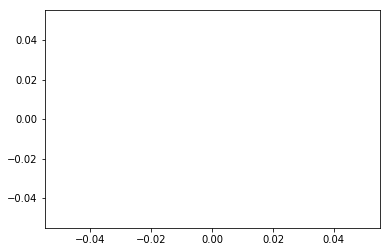

In [20]:
# 100 iterations CV mean score: 3.6810, std: 0.0680. learning_rate': 0.05, depth': 7, l2_leaf_reg': 8, 'od_wait': 10,
# 1000 iterations CV mean score: 3.6670, std: 0.0658. learning_rate': 0.05, depth': 7, l2_leaf_reg': 8, 'od_wait': 10,
# 1000 iterations CV mean score: 3.6666, std: 0.0680. learning_rate': 0.03, depth': 9, l2_leaf_reg': 8, 'od_wait': 10,
# 5000 iterations CV mean score: 3.6671, std: 0.0689. learning_rate': 0.04, depth': 7, l2_leaf_reg': 8, 'od_wait': 10,
# 200 iterations CV mean score: 3.6679, std: 0.0592. learning_rate': 0.05, depth': 8, l2_leaf_reg': 10, 'od_wait': 10,
# 700 iterations CV mean score: 3.6677, std: 0.0572. learning_rate': 0.04, depth': 10, l2_leaf_reg': 10, 'od_wait': 10,
# 300 iterations CV mean score: 3.6699, std: 0.1182. learning_rate': 0.03, depth': 7, l2_leaf_reg': 7, 'od_wait': 10,
# 1000 iterations CV mean score: 3.6670, std: 0.105. learning_rate': 0.04, depth': 8, l2_leaf_reg': 8, 'od_wait': 10,

cat_params = {'learning_rate': 0.03,
              'depth': 9,
              'l2_leaf_reg': 8,
              'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter',
              'od_wait': 10,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

In [21]:
submission['target'] = prediction_cat
submission.to_csv('cat_last.csv', index=False)

In [22]:
submission['target'] = (prediction_lgb + prediction_cat) / 2
submission.to_csv('blend_last.csv', index=False)

Let's stack the results

In [23]:
train_stack = np.vstack([oof_lgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack)
test_stack = np.vstack([prediction_lgb, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [24]:
oof_lgb_stack, prediction_lgb_stack = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb')

Fold 0 started at Mon Mar  4 00:29:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[302]	training's rmse: 3.65213	valid_1's rmse: 3.67959
Fold 1 started at Mon Mar  4 00:30:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[546]	training's rmse: 3.65861	valid_1's rmse: 3.60756
Fold 2 started at Mon Mar  4 00:30:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 3.62596	valid_1's rmse: 3.86816
Fold 3 started at Mon Mar  4 00:30:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[644]	training's rmse: 3.64094	valid_1's rmse: 3.7476
Fold 4 started at Mon Mar  4 00:30:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[638]	training's rmse: 3.66368	valid_1's rmse: 3.56911
Fold 5 started at Mon

In [25]:
submission['target'] = prediction_lgb_stack
submission.to_csv('stacker_last.csv', index=False)